# Patents

## Abstract

Protecting intellectual property through patents is a cornerstone of Western innovation. Yet, there is no global consensus on whether patents promote or stall innovation, and whether that innovation is in turn rewarded by markets. In this project, we propose to observe how companies applying for and being granted patents relates to their market capitalization and earnings. We build a graph database by combining a patent citations dataset and associated metadata. We then explore the resulting dataset to extract correlations and insight into companies' valuations in relation to their patent portfolio. Finally, we dig deeper into select companies to correlate patent activity with earnings and financial indicators such as stock prices.

## Imports & Configuration

In [663]:
# Imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import requests
import io
import urllib.request
import os
import zipfile
import gzip
import unicodedata
import re
import networkx as nx
import operator
from bs4 import BeautifulSoup

In [664]:
DATA_PATH = 'data'

## Collecting Datasets, Data Cleaning, Enrichment

### NBER Patent Dataset

We begin by collecting patent data (or metadata) associated with the period of interest (1963 - 1999). This information is available from the US National Bureau of Economic Research (NBER) [here](http://www.nber.org/patents/).

We collect and combine the different datasets provided by NBER, in particular general patent data, classes and categories, assignees, associated companies, etc. The objective of this phase is to have a complete dataframe containing all necessary patent *metadata* for our subsequent analysis.

We start with some configuration definitions.

In [665]:
# General patent data
PATENT_DATA_URL = 'http://www.nber.org/patents/apat63_99.zip'
PATENT_DATA_FILENAME = 'apat63_99.txt'
PATENT_DATA_PATH = DATA_PATH + '/' + 'patent-data.csv'

# Patent classes
PATENT_CLASSES_URL = 'http://www.nber.org/patents/list_of_classes.txt'
PATENT_CLASSES_PATH = DATA_PATH + '/' + 'patent-classes.txt'

# Patent assignees
PATENT_ASSIGNEES_URL = 'http://www.nber.org/patents/aconame.zip'
PATENT_ASSIGNEES_FILENAME = 'aconame.txt'
PATENT_ASSIGNEES_PATH = DATA_PATH + '/' + 'patent-assignees.csv'

# Patent CUSIP numbers (Committee on Uniform Securities Identification Procedures)
# Essentially a mapping between assignees and company/parent company/identifiers
PATENT_CUSIPS_URL = 'http://www.nber.org/patents/amatch.zip'
PATENT_CUSIPS_FILENAME = 'match.csv'
PATENT_CUSIPS_PATH = DATA_PATH + '/' + 'patent-cusips.csv'

We start by fetching the compressed data file from the NBER's website, which we extract into our data directory, and rename accordingly.

In [666]:
response = urllib.request.urlopen(PATENT_DATA_URL)
compressed_file = io.BytesIO(response.read())
decompressed_file = zipfile.ZipFile(compressed_file)
decompressed_file.extractall(DATA_PATH)
os.rename(DATA_PATH + '/' + PATENT_DATA_FILENAME, PATENT_DATA_PATH)

We can now load the data into a pandas dataframe and take a look...

In [667]:
patent_data = pd.read_csv(PATENT_DATA_PATH)
patent_data.columns = map(str.lower, patent_data.columns)
patent_data

,patent,gyear,gdate,appyear,country,postate,assignee,asscode,claims,nclass,...,creceive,ratiocit,general,original,fwdaplag,bckgtlag,selfctub,selfctlb,secdupbd,secdlwbd
0,3070801,1963,1096,NaN,BE,NaN,NaN,1,NaN,269,...,1,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3070802,1963,1096,NaN,US,TX,NaN,1,NaN,2,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3070803,1963,1096,NaN,US,IL,NaN,1,NaN,2,...,9,NaN,0.3704,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3070804,1963,1096,NaN,US,OH,NaN,1,NaN,2,...,3,NaN,0.6667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3070805,1963,1096,NaN,US,CA,NaN,1,NaN,2,...,1,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3070806,1963,1096,NaN,US,PA,NaN,1,NaN,2,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,3070807,1963,1096,NaN,US,OH,NaN,1,NaN,623,...,3,NaN,0.4444,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3070808,1963,1096,NaN,US,IA,NaN,1,NaN,623,...,4,NaN,0.3750,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,3070809,1963,1096,NaN,US,AZ,NaN,1,NaN,4,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,3070810,1963,1096,NaN,US,IL,NaN,1,NaN,4,...,3,NaN,0.4444,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The above is a very good start, but it is not sufficient for our purposes. In particular, patent assignees and patent classes, categories, etc. are all identified by numbers. We now seek to enrich that data using additional mappings provided by the NBER. This enrichment will allow us to obtain a dataframe containing patent class and category names, assignee names and company information.

We begin by fetching the classes mapping, which we write into our data folder.

In [668]:
response = urllib.request.urlopen(PATENT_CLASSES_URL)
file = io.BytesIO(response.read())

with open(PATENT_CLASSES_PATH, 'wb') as outfile:
    outfile.write(file.read())

We can now load this file into a dataframe and see what it looks like. Since this is a text file with tab-separated columns and a few lines of of description at the beginning, we load the data with pandas' CSV parser using a tab character separator (`\t`) and skip the unwanted rows.

In [669]:
patent_classes = pd.read_csv(PATENT_CLASSES_PATH, sep='\t', skiprows=list(range(0,7)) + [8])
patent_classes.columns = ['nclass', 'nclass_title']
patent_classes

,nclass,nclass_title
0,1,** Classification Undetermined **
1,2,Apparel
2,4,"Baths, Closets, Sinks, and Spittoons"
3,5,Beds
4,7,Compound Tools
5,8,Bleaching and Dyeing; Fluid Treatment and Chem...
6,12,Boot and Shoe Making
7,14,Bridges
8,15,"Brushing, Scrubbing, and General Cleaning"
9,16,Miscellaneous Hardware


This is basically a simple mapping from class identifier to class name.

We now move on to the patent assignees. As before, we collect the data from NBER's website. This time, the data is in CSV format, contained within a ZIP.

In [670]:
response = urllib.request.urlopen(PATENT_ASSIGNEES_URL)
compressed_file = io.BytesIO(response.read())
decompressed_file = zipfile.ZipFile(compressed_file)
decompressed_file.extractall(DATA_PATH)
os.rename(DATA_PATH + '/' + PATENT_ASSIGNEES_FILENAME, PATENT_ASSIGNEES_PATH)

We can now load the corresponding CSV and observe the mapping.

In [671]:
patent_assignees = pd.read_csv(PATENT_ASSIGNEES_PATH)
patent_assignees.columns = map(str.lower, patent_assignees.columns)
patent_assignees

,assignee,compname
0,5,"AAA ASSOCIATES, INC."
1,10,"AAA OFFICE COFFEE SERVICE, INC."
2,15,AAA PIPE CLEANING CORPORATION
3,20,AAA PRODUCTS INTERNATIONAL INC.
4,25,"AAA SALES & ENGINEERING, INC."
5,30,AAA STEEL AND ENTERPRISES CORP.
6,35,AA. BROVIG A.S.
7,40,AACCURATE COUNTERS COMPANY
8,50,A. A. COMPUTERIZED SECURITY DOORS 1989 LTD.
9,55,"AADAMS MERCHANDISING, INC."


As for classes, this is a simple map from assignee identifier to assignee name.

Finally, we move on to the CUSIP patent dataset. This dataset contains additional details on patent assignees, specifically company name, company identifier (CUSIP), and parent company. As for the assignee data, this is CSV file compressed in a ZIP file.

In [672]:
response = urllib.request.urlopen(PATENT_CUSIPS_URL)
compressed_file = io.BytesIO(response.read())
decompressed_file = zipfile.ZipFile(compressed_file)
decompressed_file.extractall(DATA_PATH)
os.rename(DATA_PATH + '/' + PATENT_CUSIPS_FILENAME, PATENT_CUSIPS_PATH)

We load it to see what it looks like.

In [673]:
patent_cusips = pd.read_csv(PATENT_CUSIPS_PATH)
patent_cusips.columns = map(str.lower, patent_cusips.columns)
patent_cusips

,assignee,assname,cname,cusip,own,pname,sname
0,105,AAI CORPORATION,UNITED INDUSTRIAL CORP,910671,NaN,NaN,NaN
1,220,AAR CORP,AAR CORP,000361,NaN,NaN,NaN
2,365,AB AG LABORATORIES LIMITED,DEL LABORATORIES INC,245091,NaN,NaN,NaN
3,735,ABBOTT LABORATORIES,ABBOTT LABORATORIES,002824,NaN,NaN,NaN
4,785,ABB POWER T & D CPY INC,WESTINGHOUSE ELECTRIC CORP,960402,55.0,WESTINGHOUSE ELECTRIC CORP,ABB POWER T & D CO
5,860,ABB VETCOGRAY INC.,NaN,NaN,NaN,NaN,NaN
6,1045,A B CHANCE CPY,EMERSON ELECTRIC CO,291011,100.0,EMERSON ELECTRIC CO,A B CHANCE CO
7,1175,A B DICK CPY,DICK (A.B.) CO,253034,NaN,NaN,NaN
8,1450,ABEX CORPORATION,"ABEX, INC",003387,NaN,NaN,NaN
9,1850,ABITIBI PRICE CORPORATION,ABITIBI PRICE INC,003680,NaN,NaN,NaN


This is simply a map between assignee identifier and tuples containing assignee details. We notice that this dataset is significantly smaller than the assignee dataset mapping identifier to name. Perhaps this is due to the difficulty of collecting such information about companies. It is also possible that various unlisted companies do not appear in this list (since they do not possess a CUSIP), while still potentially holding patents.

We can proceed to merge the data, joining on the attributes of interest (`nclass` for patent class, `assignee` for patent assignees). We use inner joins for patent classes and assignee names, but a left join for CUSIPs (in the hope of preserving some salvageable data).

Once the data is merged, we index it by patent number and sort it for good measure.

In [674]:
patents = patent_data.merge(patent_classes).merge(patent_assignees).merge(patent_cusips, how='left')
patents.set_index(['patent'], inplace=True)
patents.sort_index(inplace=True)
patents

,gyear,gdate,appyear,country,postate,assignee,asscode,claims,nclass,cat,...,secdupbd,secdlwbd,nclass_title,compname,assname,cname,cusip,own,pname,sname
patent,,,,,,,,,,,,,,,,,,,,,
3397088,1968,3147,1964.0,US,CA,361390,2,NaN,429,4,...,0.0000,0.0000,Chemistry: Electrical Current Producing Appar...,MCDONNELL DOUGLAS CORP.,MCDONNELL DOUGLAS CORP,MCDONNELL DOUGLAS CORP,580169,NaN,NaN,NaN
3419907,1969,3294,1966.0,DE,NaN,498570,3,NaN,2,6,...,0.0000,0.0000,Apparel,SCHUBERTH-WERK K.G.,NaN,NaN,NaN,NaN,NaN,NaN
3419911,1969,3294,1966.0,US,PA,26640,2,NaN,4,6,...,0.0000,0.0000,"Baths, Closets, Sinks, and Spittoons",AMERICAN STERILIZER COMPANY,AMERICAN STERILIZER CPY,AMERICAN STERILIZER CO,030087,NaN,NaN,NaN
3419915,1969,3294,1966.0,US,CT,218550,2,NaN,4,6,...,0.0000,0.0000,"Baths, Closets, Sinks, and Spittoons",GENERAL ELECTRIC COMPANY,GENERAL ELECTRIC CPY,GENERAL ELECTRIC CO-PRE FASB,36999Z,NaN,NaN,NaN
3419915,1969,3294,1966.0,US,CT,218550,2,NaN,4,6,...,0.0000,0.0000,"Baths, Closets, Sinks, and Spittoons",GENERAL ELECTRIC COMPANY,GENERAL ELECTRIC COMPANY,GENERAL ELECTRIC CO,369604,NaN,NaN,NaN
3419919,1969,3294,1966.0,US,IL,191235,2,NaN,4,6,...,0.0000,0.0000,"Baths, Closets, Sinks, and Spittoons",FEDERAL-HUBER CORPORATION,NaN,NaN,NaN,NaN,NaN,NaN
3419922,1969,3294,1966.0,US,CA,184725,2,NaN,5,6,...,0.0000,0.0000,Beds,"EVEREST + JENNINGS, INC.",EVEREST & JENNINGS INC,EVEREST & JENNINGS -CL A,299767,NaN,NaN,NaN
3419925,1969,3294,1966.0,CA,NaN,150560,3,NaN,8,1,...,0.0000,0.0000,Bleaching and Dyeing; Fluid Treatment and Chem...,DOBBIE INDUSTRIES LIMITED,NaN,NaN,NaN,NaN,NaN,NaN
3419929,1969,3294,1967.0,US,MA,544845,2,NaN,12,6,...,0.0000,0.0000,Boot and Shoe Making,"STETSON SHOE, AND BATCHELDER-RUBICO, INC.",NaN,NaN,NaN,NaN,NaN,NaN


We now have a nice little dataset containing various patent (meta)data that we can work with.

### Stanford Patent Citation Graph

The second dataset of interest for this project is the patent citation graph from Stanford University. This graph was built using patents from 1963 to 1999. Although we would have wished to go all the way to 2017, this is already a pretty comprehensive dataset.

This dataset takes the form of a graph whose nodes correspond to patent, and who edges represent patent citations.

We start by downloading the graph data from the Stanford website. The data is structured as an edge list in NET format, i.e. source vertex $\rightarrow$ target vertex (the source cites the target). It is compressed using GZIP, so we extract it and write the output file in out data folder.

In [675]:
CITATION_GRAPH_URL = 'http://snap.stanford.edu/data/cit-Patents.txt.gz'
CITATION_GRAPH_PATH = DATA_PATH + '/' + 'patent-citations.edgefile'

In [676]:
response = urllib.request.urlopen(CITATION_GRAPH_URL)
compressed_file = io.BytesIO(response.read())
decompressed_file = gzip.GzipFile(fileobj=compressed_file)

with open(CITATION_GRAPH_PATH, 'wb') as outfile:
    outfile.write(decompressed_file.read())

Pandas is not the best suited option to work with graph-structured data. If we had a very large graph, we could use analytics frameworks such as GraphX or Chaos (system built by a team member). However, the graph input is a mere hundreds of megabytes, so we can directly use python, specifically the `networkx` package for convience.

We begin by loading the edgelist, creating a ***directed graph***.

In [677]:
G = nx.read_edgelist(CITATION_GRAPH_PATH, create_using=nx.DiGraph(), nodetype=int)
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 3774768
Number of edges: 16518948
Average in degree:   4.3761
Average out degree:   4.3761


As we can see, the graph has almost 4 million vertices and 16 millions edges.

### S&P 500 Components & Valuation Dataset

The third component of our analysis corresponds to actual market information that we can use to correlate with patent information, specifically assignees.

We opt to use the ***Standard & Poor's 500*** (S&P 500) stock market index, which is based on the market capitalizations of 500 large companies. This allows us to look at the world's largest companies and compare patents granted to these companies with their market capitalizations.

We can build our own market dataset by collecting information on the top 10 components (companies) in the S&P 500. Specifically, it is relatively easy to parse the contents of [this webpage](http://etfdb.com/history-of-the-s-and-p-500) to collect the top 10 for each year since 1980 along with each company's market capitalization (in M$).

We use `BeautifulSoup` along with `requests` to extract the relevant data.

In [678]:
SP500_TOP10_URL = 'http://etfdb.com/history-of-the-s-and-p-500'
SP500_TOP10_PATH = DATA_PATH + '/' + 'sp500_top10.csv'
SP500_START = 1980
SP500_NUM_PER_YEAR = 10

In [679]:
r = requests.get(SP500_TOP10_URL)
soup = BeautifulSoup(r.text, 'lxml')
titles = list(map(lambda e: e.get_text().strip(), soup.select('span.rowTitle')))
marketcaps = list(map(lambda e: int(e.get_text().strip().replace('$', '').replace(',', '')), soup.select('div.colFill div')))

In [680]:
assert(len(titles) == len(marketcaps)) # make sure we get the same number for both

We can now build a dataframe indexed by year and rank that contains the ranking and market capitalization of the top 10 components in the S&P 500.

In [681]:
sp500 = pd.DataFrame([(SP500_START + yearoffset, i+1, titles[yearoffset * SP500_NUM_PER_YEAR + i], marketcaps[yearoffset * SP500_NUM_PER_YEAR + i]) for i in range(0, SP500_NUM_PER_YEAR) for yearoffset in range(0,int(len(list(titles)) / SP500_NUM_PER_YEAR))])
sp500.columns = ['year', 'rank', 'company', 'marketcap']
sp500.set_index(['year', 'rank'], inplace=True)
sp500.sort_index(inplace=True)

This is what it looks like.

In [682]:
sp500

company  marketcap
year rank                                       
1980 1                            IBM      39604
     2                           AT&T      35676
     3                          Exxon      34856
     4        Standard Oil of Indiana      23365
     5                   Schlumberger      22331
     6                      Shell Oil      17990
     7                          Mobil      17163
     8     Standard Oil of California      17020
     9             Atlantic Richfield      15030
     10              General Electric      13883
1981 1                           AT&T      47750
     2                            IBM      33587
     3                          Exxon      27071
     4                   Schlumberger      16170
     5        Standard Oil of Indiana      15378
     6     Standard Oil of California      14666
     7                      Shell Oil      13594
     8               General Electric      13072
     9                 General Motors      11590
     10                 Eastman Kodak      11478
1982 1                            IBM      57794
     2                           AT&T      52989
     3                          Exxon      25863
     4               General Electric      21555
     5                 General Motors      19176
     6                  Eastman Kodak      14250
     7                   Schlumberger      13643
     8        Standard Oil of Indiana      11630
     9                      Shell Oil      11433
     10    Standard Oil of California      10947
...                               ...        ...
2011 1                    Exxon Mobil     406272
     2                          Apple     376411
     3                      Microsoft     218380
     4                            IBM     216724
     5                        Chevron     211894
     6                         Google     209199
     7                Wal-Mart Stores     204660
     8               General Electric     189082
     9             Berkshire Hathaway     188929
     10              Procter & Gamble     183541
2012 1                          Apple     498275
     2                    Exxon Mobil     403867
     3                      Microsoft     228170
     4               General Electric     226714
     5                            IBM     216936
     6                        Chevron     211199
     7              Johnson & Johnson     196067
     8                           AT&T     194938
     9               Procter & Gamble     191752
     10                        Pfizer     186494
2013 1                          Apple     481110
     2                    Exxon Mobil     439190
     3                         Google     381000
     4                      Microsoft     297900
     5               General Electric     275600
     6              Johnson & Johnson     265340
     7                        Chevron     236490
     8               Procter & Gamble     241300
     9                 JPMorgan Chase     220700
     10                   Wells Fargo     218100

[340 rows x 2 columns]

Since we have just collected ourselves a nice little dataset, let's save it to a CSV file.

In [683]:
sp500.to_csv(SP500_TOP10_PATH)

### Additional Data Sources

Our current financial information dataset is bit small and poor in terms of information. We spent some time looking for richer datasets that we could use and ended up finding that [Wharton Research Data Services](https://wrds-web.wharton.upenn.edu/wrds/) would provide us with additional datasets with valuable information. We would particularly be interested in other kinds of information regarding companies in the S&P 500. For instance, it we had quarterly earnings, we could correlate this information with the company's granted patents.

We have applied for a free account at WRDS, but have not yet been granted access. We will beef up our S&P dataset if/when we do.

### Connecting the Dots

Our datasets are now loaded and ready to be used, but we still need to solve one problem: linking them together. The companies in the S&P 500 must be linked with the patent assignees in the patent dataset. Similarly, we must ensure that every node in the citation graph corresponds to a patent entry in the patent dataset.

#### Linking S&P 500 Companies with Patents Assignees

At first glance, it is pretty clear that company names are not going to be that easy to match. The patent dataset contains companies in uppercase, while the company names in the S&P list are in title case. The case is, however, the least of our worries. Many company names in the patent dataset end with *Co*, *Inc*, *Corp*, *LTD*, etc. Some companies have different word orderings, use abbreviations, or hyphens. Some companies have also renamed (e.g., Exxon became Exxon Mobil in 1998).

Note: We cannot go through CUSIP for the matching because the CUSIPs in the patent datasets are in an old format and it is not easy to look them up. Also, Standard & Poor (who run the CUSIP Service Bureau) thought it would be a good idea to reassign the same CUSIP to different companies over time and perform the mapping in a very opaque manner...

We begin by listing all unique companies in the S&P dataset.

In [684]:
companies = sp500.loc[:(1999,10)].company.unique()
companies

array(['IBM', 'AT&T', 'Exxon', 'Standard Oil of Indiana', 'Schlumberger',
       'Shell Oil', 'Mobil', 'Standard Oil of California',
       'Atlantic Richfield', 'General Electric', 'General Motors',
       'Eastman Kodak', 'Sears Roebuck', 'duPont', 'Royal Dutch Petrol',
       'Amoco', 'BellSouth', 'Philip Morris', 'Merck', 'Ford Motor',
       'Bristol-Myers Squibb', 'Wal-Mart Stores', 'Coca-Cola',
       'Procter & Gamble', 'AT&T Corp', 'Johnson & Johnson', 'Microsoft',
       'Intel', 'Pfizer', 'Cisco Systems', 'Exxon Mobil',
       'Lucent Technologies', 'Citigroup', 'America Online'], dtype=object)

As a first step to construct the mapping, we match the S&P company name to the company names in the patents CUSIP dataframe. The matching is done automatically based on the patents company name starting with the S&P company name (this allows us to easily match without caring about suffixes).

In [685]:
company_mapping = pd.DataFrame([(company, row[1][0], row[1][1]) for company in companies for row in patent_cusips[['assignee', 'cname']].dropna().iterrows() if row[1][1].startswith(company.upper())])
company_mapping.columns = ['sp_name', 'assignee', 'p_name']
company_mapping

,sp_name,assignee,p_name
0,AT&T,706518,AT&T CORP.
1,AT&T,713790,AT&T ??
2,Exxon,186560,EXXON CORP
3,Exxon,186585,EXXON CORP
4,Exxon,186590,EXXON CORP
5,Exxon,686547,EXXON CORP
6,Schlumberger,28775,SCHLUMBERGER LTD
7,Schlumberger,33110,SCHLUMBERGER LTD
8,Schlumberger,258475,SCHLUMBERGER LTD
9,Schlumberger,396910,SCHLUMBERGER LTD


In [686]:
companies_found = company_mapping.sp_name.unique()
len(companies_found)

23

Not bad: we matched 23! Now let us see which companies could not be matched automatically.

In [687]:
missing_companies = [name for name in companies if name not in companies_found]
missing_companies

['IBM',
 'Standard Oil of Indiana',
 'Standard Oil of California',
 'duPont',
 'Royal Dutch Petrol',
 'Bristol-Myers Squibb',
 'Wal-Mart Stores',
 'Microsoft',
 'Exxon Mobil',
 'Citigroup',
 'America Online']

Ouch! Still a quarter of the companies (11) unaccounted for. Trying other matchings based on string similarity or abbreviations seems very error prone and could compromise the quality of our data. We opt to complete the work manually instead.

We console ourselves by observing that this process ***has to be partially manual*** since some of these companies have been split and/or renamed, and could never have been matched automatically. This is especially true for oil companies. *Royal Dutch Corp* is actually *Shell*. *Standard Oil *was split into 34 different companies, with *Standard Oil of Indiana* becoming *Amoco* and *Standard Oil of California* becoming *Chevron Corp*. There are other special cases, such as *IBM*, which is the abbreviation of *International Business Machines*.

In the following paragraphs, we are going to go through each unmatched company, find the corresponding company in the patents dataset, and add the matching(s) to the dataframe we built above.

We start by writing a small helper function which takes a subset of the patents CUSIP dataframe corresponding to a company along with the company name in the S&P 500 dataset, and combines them into a dataframe which can easily be appended to the mapping we are constructing.

In [688]:
def company_df(df, sp_name):
    df = df.copy()
    df.columns = ['assignee', 'p_name']
    df['sp_name'] = sp_name
    return df

We remove some N/As from the dataset to facilitate the search.

In [689]:
companies_ref = patent_cusips.dropna(subset=['assignee', 'cname'])

Let us now go through each missing company one by one...

>IBM

In [690]:
companies_ref[companies_ref.cname.str.match('I.*BUSINESS.*MACHINES')].cname.unique()

array(['INTL BUSINESS MACHINES CORP'], dtype=object)

In [691]:
ibm_df = company_df(companies_ref.loc[companies_ref.cname == 'INTL BUSINESS MACHINES CORP', ['assignee', 'cname']], 'IBM')
company_mapping = company_mapping.append(ibm_df)

> Standard Oil of Indiana (Amoco)

In [692]:
companies_ref[companies_ref.cname.str.match('AMOCO')].cname.unique()

array(['AMOCO CORP', 'AMOCO CO', 'AMOCO (NC 86)'], dtype=object)

In [693]:
amoco_df = company_df(companies_ref.loc[companies_ref.cname.str.startswith('AMOCO'), ['assignee', 'cname']], 'Standard Oil of Indiana')
company_mapping = company_mapping.append(amoco_df)

> Standard Oil of California (Chevron Corp)

In [694]:
companies_ref[companies_ref.cname.str.match('CHEVRON')].cname.unique()

array(['CHEVRON CORP'], dtype=object)

In [695]:
chevron_df = company_df(companies_ref.loc[companies_ref.cname == 'CHEVRON CORP', ['assignee', 'cname']], 'Standard Oil of California')
company_mapping = company_mapping.append(chevron_df)

> duPont

In [696]:
companies_ref[companies_ref.cname.str.match('DU.*PONT')].cname.unique()

array(['DU PONT (E I) DE NEMOURS', 'DU PONT (E.I.) DE NEMOURS'], dtype=object)

In [697]:
dupont_df = company_df(companies_ref.loc[companies_ref.cname.str.startswith('DU PONT'), ['assignee', 'cname']], 'duPont')
company_mapping = company_mapping.append(dupont_df)

> Royal Dutch Petrol (Shell)

In [698]:
companies_ref[companies_ref.cname.str.match('SHELL')].cname.unique()

array(['SHELLER-GLOBE', 'SHELL OIL CO'], dtype=object)

In [699]:
shell_df = company_df(companies_ref.loc[companies_ref.cname == 'SHELL OIL CO', ['assignee', 'cname']], 'Royal Dutch Petrol')
company_mapping = company_mapping.append(shell_df)

> Bristol-Myers Squibb

In [700]:
companies_ref[companies_ref.cname.str.match('BRISTOL.*MYERS')].cname.unique()

array(['BRISTOL MYERS SQUIBB'], dtype=object)

In [701]:
bms_df = company_df(companies_ref.loc[companies_ref.cname == 'BRISTOL MYERS SQUIBB', ['assignee', 'cname']], 'Bristol-Myers Squibb')
company_mapping = company_mapping.append(bms_df)

> Wal-Mart Stores

In [702]:
companies_ref[companies_ref.cname.str.match('(WAL)|(MART)')].cname.unique()

array(['WALTER (JIM) CORP', 'MARTHA WHITE FOODS INC',
       'MARTIN MARIETTA CORP', 'MARTIN PROCESSING INC', 'WALBRO CORP',
       'WALCO NATIONAL CORP', 'WALLACE COMPUTER SERVICES INC',
       'WALLACE-MURRAY CORP'], dtype=object)

It seems like Wal-Mart Stores have no patents.

> Microsoft

In [703]:
companies_ref[companies_ref.cname.str.match('MI.*SOFT')].cname.unique()

array(['MIRCOSOFT CORP'], dtype=object)

It seems they managed to misspell the company name. Nice work!

In [704]:
msft_df = company_df(companies_ref.loc[companies_ref.cname == 'MIRCOSOFT CORP', ['assignee', 'cname']], 'Microsoft')
company_mapping = company_mapping.append(msft_df)

> Exxon Mobil (renamed in 1998)

In [705]:
companies_ref[companies_ref.cname.str.match('EXXON')].cname.unique()

array(['EXXON CORP'], dtype=object)

In [706]:
exxon_df = company_df(companies_ref.loc[companies_ref.cname == 'EXXON CORP', ['assignee', 'cname']], 'Exxon Mobil')
company_mapping = company_mapping.append(exxon_df)

> Citigroup

In [707]:
companies_ref[companies_ref.cname.str.match('CITI')].cname.unique()

array(['CITICORP', 'CITIZENS & SOUTHERN CORP-GA'], dtype=object)

In [708]:
citi_df = company_df(companies_ref.loc[companies_ref.cname == 'CITICORP', ['assignee', 'cname']], 'Citigroup')
company_mapping = company_mapping.append(citi_df)

> America Online

In [709]:
companies_ref[companies_ref.cname.str.match('AOL')].cname.unique()

array([], dtype=object)

It appears America Online (AOL) has no patents.

Alright! We are done! The mapping is now complete. Let's take a look...

In [710]:
company_mapping

,assignee,p_name,sp_name
0,706518,AT&T CORP.,AT&T
1,713790,AT&T ??,AT&T
2,186560,EXXON CORP,Exxon
3,186585,EXXON CORP,Exxon
4,186590,EXXON CORP,Exxon
5,686547,EXXON CORP,Exxon
6,28775,SCHLUMBERGER LTD,Schlumberger
7,33110,SCHLUMBERGER LTD,Schlumberger
8,258475,SCHLUMBERGER LTD,Schlumberger
9,396910,SCHLUMBERGER LTD,Schlumberger


And just to make sure we did not make a mistake, let us check again which companies are missing from the mapping.

In [711]:
companies_found = company_mapping.sp_name.unique()
missing_companies = [name for name in companies if name not in companies_found]
missing_companies

['Wal-Mart Stores', 'America Online']

Perfect! Only Walmart and AOL are missing, both of which we identified as not having been granted any patents in the period of interest.

#### Patents Unaccounted for in Patent Citation Graph

We now consider the patent citation graph we built previously and ensure that it only contains nodes that are accounted for in the patent dataset. We believe it is alright to remove such nodes because there is little use for nodes which have no associated metadata, as they cannot be analyzed beyond their structural makeup. Removing them should not damage the credibility of our conclusions since we already know that the S&P 500 companies we are interested are present and accounted for in the dataset.

In [712]:
print('There are %d nodes in the citation graph.' % len(G.nodes))
print('There are %d patents in the patents dataset.' % len(patents))

There are 3774768 nodes in the citation graph.
There are 2117755 patents in the patents dataset.


In [713]:
patent_ids = frozenset(patents.index.values)
graph_nodes = list(G.nodes)
for node in graph_nodes:
    if node not in patent_ids:
        G.remove_node(node)

In [714]:
print('There are %d nodes after removal in the citation graph.' % len(G.nodes))

There are 2021723 nodes after removal in the citation graph.


Our datasets are now ready for analysis.

## Analysis

### Basic Metrics and Data Quality

We begin by extracting basic information regarding our datasets, in particular how many patents were applied for, and granted per year. We also look at the distribution of patents to countries. Finally, we estimate the quality of our data by counting missing features.

#### Total Patents Applications per Year

Text(0,0.5,'Number of Patent Applications')

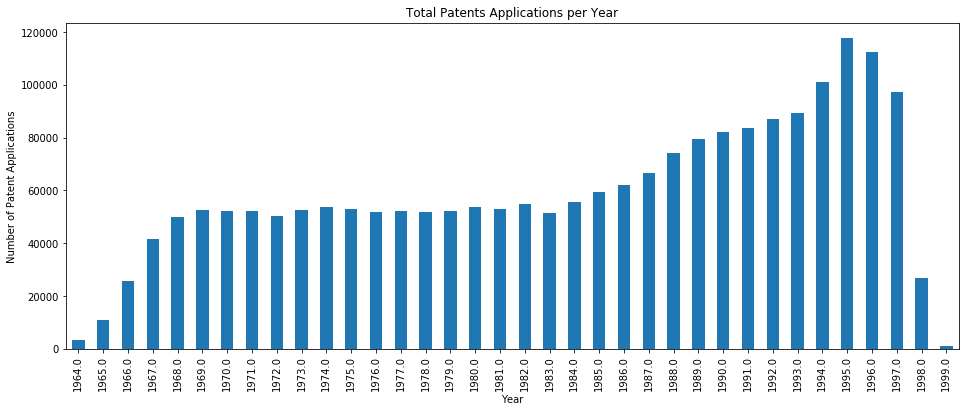

In [715]:
apps_per_year = patents.groupby('appyear').size()
apps_per_year = apps_per_year[apps_per_year >= 1000]
plt = apps_per_year.plot(kind='bar',title='Total Patents Applications per Year',figsize=(16,6))
plt.set_xlabel('Year')
plt.set_ylabel('Number of Patent Applications')

As we can see, the total number of applications stayed steady until 1982, and then started climbing. Although there was a financial crisis in 1997 which could have caused a slowdown in patent applications, we believe the drop at the end is due to the end of the data collection, but not to a slowdown in applications.

#### Total Patents Granted per Year

Text(0,0.5,'Number of Patents Granted')

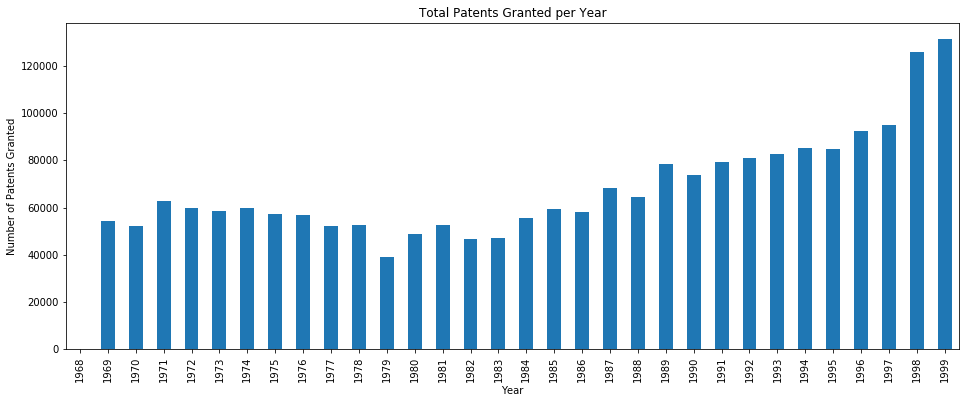

In [716]:
plt = patents.groupby('gyear').size().plot(kind='bar',title='Total Patents Granted per Year',figsize=(16,6))
plt.set_xlabel('Year')
plt.set_ylabel('Number of Patents Granted')

The number of granted patents follows roughly the same distribution as the patent applications, albeit with a little shift to the right since patents typically take a few years before being granted.

#### Total Patents per Country

Text(0,0.5,'Number of Patents')

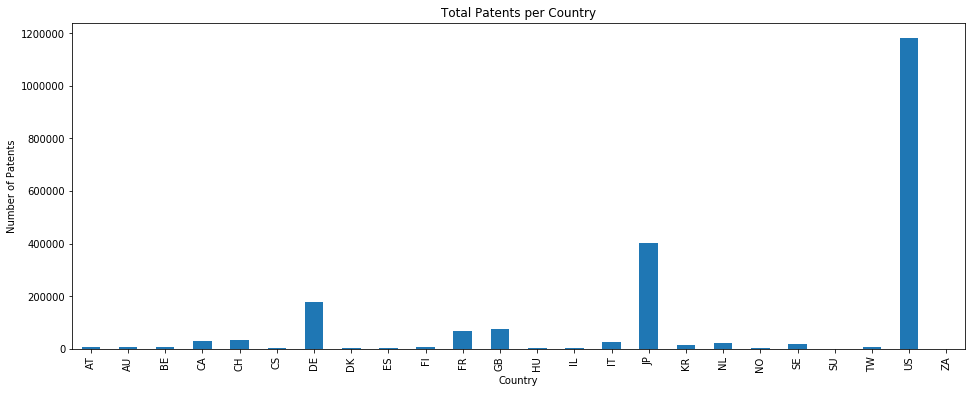

In [717]:
by_country = patents.groupby('country').size()
by_country = by_country[by_country >= 1000]
plt = by_country.plot(kind='bar',title='Total Patents per Country',figsize=(16,6))
plt.set_xlabel('Country')
plt.set_ylabel('Number of Patents')

There is a clear winner here: the United States has by far the most patents, followed by Japan and Germany. France and Great Britain are trailing.

#### Total Patents per Class

In [718]:
by_class = pd.DataFrame({ 'num_patents': patents.groupby('nclass_title').size() })
by_class.sort_values('num_patents', ascending=False)

,num_patents
nclass_title,
Organic Compounds -- Part of the Class 532-570 Series,102644
Synthetic Resins or Natural Rubbers -- Part of the Class 520 Series,82986
"Drug, Bio-Affecting and Body Treating Compositions",75455
Stock Material or Miscellaneous Articles,40195
Surgery,38192
"Radiation Imagery Chemistry: Process, Composition, or Product Thereof",29366
Measuring and Testing,29270
Chemistry: Molecular Biology and Microbiology,27279
Radiant Energy,23931


As we can observe, the top 10 is almost entirely composed of bio and medtech. Energy, oil, etc. are within the top 20. Semiconductors, computers and networking barely crack the top 100 since these are more recent fields.

#### Missing Features

We list the number of missing features (not present in the dataset) for each patent below.

In [719]:
number = []
col = []
for feature in patents.columns:
    if patents[feature].isnull().sum() != 0:
        number.append(patents[feature].isnull().sum())
        col.append(feature)
    

missing = pd.DataFrame(number,col)
missing

,0
appyear,4
postate,937533
claims,480510
cmade,347379
ratiocit,393832
general,495408
original,423129
fwdaplag,495410
bckgtlag,393842
selfctub,393832


### Patents and Presence in S&P 500

We begin our analysis by listing the top 100 patent holders in the patents dataset and compare that to the companies in the top 10 of the S&P 500.

In [720]:
top_100_patent_holders = pd.DataFrame({ 'num_patents': patents.groupby('cname').size() }).sort_values('num_patents', ascending=False).head(100)
top_100_patent_holders

,num_patents
cname,
GENERAL ELECTRIC CO,26359
INTL BUSINESS MACHINES CORP,26342
GENERAL ELECTRIC CO-PRE FASB,25868
HITACHI LTD -ADR,19055
GENERAL MOTORS CORP,17891
NORTH AMERICAN PHILIPS CORP,16371
EASTMAN KODAK CO,16369
AT&T CORP.,14837
MOTOROLA INC,13753


Let us see how many of those 100 companies also appear in the S&P 500 top 10.

In [721]:
companies_in_top = top_50_patent_holders.reset_index().merge(company_mapping, left_on='cname', right_on='p_name').sp_name.unique()
print('There are %d companies in the top 100 of patent holders out of %d which are also in the S&P 500 top 10.' % (len(companies_in_top), len(company_mapping.sp_name.unique())))

There are 24 companies in the top 100 of patent holders out of 32 which are also in the S&P 500 top 10.


Clearly, 3/4 of the most valued companies are also big patent holders.

### Patents and Company Valuation

We next attempt to determine whether or not there is a correlation between the number of patents owned by a company and market capitalization (as well as its ranking in the S&P 500).

To that end, we select the S&P ranking before year 2000 and use our company mapping dataset to merge it with our patents dataset. For each entry in the ranking, we associate the number of patents *granted* to that company until the end of the corresponding year. Finally we display the results.

In [722]:
sp500_b2000 = sp500.loc[:2000]
df = sp500_b2000.reset_index().merge(company_mapping, left_on='company', right_on='sp_name').merge(patents, on='assignee')
patent_valuation = pd.DataFrame({ 'num_patents': df.loc[df.gyear <= df.year, ['year', 'rank', 'company', 'marketcap']].groupby(['year', 'rank', 'company', 'marketcap']).size() }).reset_index()
patent_valuation

,year,rank,company,marketcap,num_patents
0,1980,1,IBM,39604,6469
1,1980,2,AT&T,35676,6902
2,1980,3,Exxon,34856,3227
3,1980,4,Standard Oil of Indiana,23365,1184
4,1980,5,Schlumberger,22331,625
5,1980,6,Shell Oil,17990,2505
6,1980,7,Mobil,17163,2134
7,1980,8,Standard Oil of California,17020,2900
8,1980,9,Atlantic Richfield,15030,1086
9,1980,10,General Electric,13883,43915


Let us see what correlations we have...

In [723]:
patent_valuation.corr()

,year,rank,marketcap,num_patents
year,1.000000,-0.004173,0.707059,0.105265
rank,-0.004173,1.000000,-0.287893,-0.348076
marketcap,0.707059,-0.287893,1.000000,0.253561
num_patents,0.105265,-0.348076,0.253561,1.000000


At first glance, it would appear that the correlation is pretty weak. However, we can easily realize that the above code is not computing the proper correlation! We are computing a general correlation which considers all companies and all valuations. The right thing to do would instead be to do this for individual companies.

For instance, if we consider only IBM, the correlation between patents and market capitalization is pretty clear.

In [724]:
patent_valuation[patent_valuation.company == 'IBM'].corr()

,year,rank,marketcap,num_patents
year,1.000000,0.852353,0.658214,0.962854
rank,0.852353,1.000000,0.382608,0.827840
marketcap,0.658214,0.382608,1.000000,0.789029
num_patents,0.962854,0.827840,0.789029,1.000000


It is even better for GE.

In [725]:
patent_valuation[patent_valuation.company == 'General Electric'].corr()

,year,rank,marketcap,num_patents
year,1.000000,-0.738754,0.808523,0.998743
rank,-0.738754,1.000000,-0.432259,-0.736799
marketcap,0.808523,-0.432259,1.000000,0.796929
num_patents,0.998743,-0.736799,0.796929,1.000000


And very strong for Intel.

In [726]:
patent_valuation[patent_valuation.company == 'Intel'].corr()

,year,rank,marketcap,num_patents
year,1.000000,0.635085,0.795588,0.972004
rank,0.635085,1.000000,0.152776,0.487745
marketcap,0.795588,0.152776,1.000000,0.915374
num_patents,0.972004,0.487745,0.915374,1.000000


We can compute the correlation factor for every company in the S&P 500 as follows.

In [727]:
correlation = patent_valuation.groupby('company')[['marketcap','num_patents']].corr()
correlation = correlation.iloc[::2, [1]].dropna().reset_index()[['company', 'num_patents']]
correlation.columns = ['company', 'correlation_factor']
correlation.set_index('company', inplace=True)
correlation

,correlation_factor
company,
AT&T,0.495871
AT&T Corp,1.000000
Amoco,1.000000
Bristol-Myers Squibb,0.503193
Cisco Systems,0.910898
Coca-Cola,0.923125
Eastman Kodak,-0.066499
Exxon,0.896430
Ford Motor,1.000000


These results are pretty interesting. There is a strong correlation for most companies, yet there are a few pretty big counter examples. For instance, Eastman Kodak, despite being on the most prolific company in terms of patent applications is not seeing that result get translated into a higher valuation. Other market forces are clearly at play. Standard Oil companies are seeing a pretty big negative correlation: the more patents they have, the lower their valuation. As a preliminary explanation for this surprising outcome, we believe there are two reasons for this: (1) these companies were created after the split of Standard Oil Co and may not have retained many patents, and (2) oil companies, due to their very nature, do not heavily rely on patents to create shareholder value.

One could be tempted to conclude from these results that we have already answered our research question and it is time to get our grade of 6 and shake hands ;-) However, it is important to remember that correlation does not imply causation. In particular, we are considering two quantities (market capitalization and number of patents) which are (naturally) increasing. It is therefore not surprising that they are somewhat correlated. More analysis is therefore required before we can safely conclude that a higher number of patents is a factor in determining a company's valuation.

#### Incomplete next step

It makes sense to consider market evolution, i.e. the evolution of the S&P 500 index, in relation with each company's market valuation. In a bull market (i.e. rising prices), valuations will increase irrespective of granted patents. We plan to use the WRDS dataset to normalize company valuations to the S&P index and evaluate the correlations again.

### Influencial Patents and Market Impact

We attempt to determine which patents have been influential and how these may have affected the capitalization of companies owning these patents. It is important to realize that patents can be licensed, and as such it may not be possible to immediately determine whether some patents contributed to a company's valuation. A classic example of this is the PageRank patent (the algorithm of which we will use later on in this analysis), which was granted to Stanford University, but licensed exclusively by Google. Such a patent would not be found through our analysis (we do not possess a patent licensee dataset), and yet was (is) a major component of Google's capitalization.

What does it mean for a patent to be influential? This is very hard to quantify. For the purposes of this analysis, we will limit ourselves to the patent citation graph, and define influence as *some* measure of the importance of a patent with respect to the whole graph.

#### Patent in-degree

The first such measure is the simplest we can come up with, namely counting the in-degree of each node in the patent citation graph and associating popularity to a high in-degree. This intuitively makes sense, as key patents within a particular field should be cited by other patents trying to cover some more "real estate" in that field.

In order to perform this analysis, we simply compute the in-degrees (number of incoming edges) for each vertex in the graph and sort the result. We normalize the degree into a column called *influence*.

In [728]:
degrees = list(G.in_degree())
infl_deg = pd.DataFrame(degrees)
infl_deg.columns = ['patent', 'degree']
infl_deg.set_index('patent', inplace=True)
infl_deg['influence'] = (infl_deg['degree']) / (infl_deg['degree'].sum())

We can merge the dataframe with the patents dataframe and sort by influence to see which patents had the most impact.

In [729]:
infl_patents = infl_deg.merge(patents, left_index=True, right_index=True)
infl_patents.sort_values('influence', ascending=False, inplace=True)
infl_patents

,degree,influence,gyear,gdate,appyear,country,postate,assignee,asscode,claims,...,secdupbd,secdlwbd,nclass_title,compname,assname,cname,cusip,own,pname,sname
patent,,,,,,,,,,,,,,,,,,,,,
4723129,773,0.000081,1988,10259,1986.0,JP,NaN,87490,3,9.0,...,0.9379,0.9307,Incremental Printing of Symbolic Information,CANON KABUSHIKI KAISHA,NaN,NaN,NaN,NaN,NaN,NaN
4463359,713,0.000075,1984,8978,1980.0,JP,NaN,87490,3,51.0,...,0.8990,0.8953,Incremental Printing of Symbolic Information,CANON KABUSHIKI KAISHA,NaN,NaN,NaN,NaN,NaN,NaN
4740796,675,0.000071,1988,10343,1986.0,JP,NaN,87490,3,10.0,...,0.9852,0.9808,Incremental Printing of Symbolic Information,CANON KABUSHIKI KAISHA,NaN,NaN,NaN,NaN,NaN,NaN
4345262,656,0.000069,1982,8264,1980.0,JP,NaN,87490,3,15.0,...,0.9497,0.9468,Incremental Printing of Symbolic Information,CANON KABUSHIKI KAISHA,NaN,NaN,NaN,NaN,NaN,NaN
4558333,652,0.000069,1985,9475,1982.0,JP,NaN,87490,3,14.0,...,0.9264,0.9235,Incremental Printing of Symbolic Information,CANON KABUSHIKI KAISHA,NaN,NaN,NaN,NaN,NaN,NaN
4313124,630,0.000066,1982,8061,1980.0,JP,NaN,87490,3,7.0,...,0.9635,0.9589,Incremental Printing of Symbolic Information,CANON KABUSHIKI KAISHA,NaN,NaN,NaN,NaN,NaN,NaN
4459600,611,0.000064,1984,8957,1981.0,JP,NaN,87490,3,2.0,...,0.9918,0.9886,Incremental Printing of Symbolic Information,CANON KABUSHIKI KAISHA,NaN,NaN,NaN,NaN,NaN,NaN
4683195,601,0.000063,1987,10070,1986.0,US,CA,97235,2,26.0,...,0.0183,0.0174,Chemistry: Molecular Biology and Microbiology,CETUS CORPORATION,CETUS CORPORATION,CETUS CORP,157199,NaN,NaN,NaN
4683202,572,0.000060,1987,10070,1985.0,US,CA,97235,2,21.0,...,0.0157,0.0149,Chemistry: Molecular Biology and Microbiology,CETUS CORPORATION,CETUS CORPORATION,CETUS CORP,157199,NaN,NaN,NaN


We can now find which was the most influential patent for each company in the S&P 500 top 10.

In [730]:
infl_patents.merge(company_mapping).groupby('sp_name').first()

,degree,influence,gyear,gdate,appyear,country,postate,assignee,asscode,claims,...,secdlwbd,nclass_title,compname,assname,cname,cusip,own,pname,sname,p_name
sp_name,,,,,,,,,,,,,,,,,,,,,
AT&T,173,0.000018,1992,11750,1989.0,US,IL,706518.0,2,21.0,...,0.0000,Information Processing System Organization,AT&T CORP.,AT&T CORP.,AT&T CORP.,001957,NaN,NaN,NaN,AT&T CORP.
AT&T Corp,173,0.000018,1992,11750,1989.0,US,IL,706518.0,2,21.0,...,0.0000,Information Processing System Organization,AT&T CORP.,AT&T CORP.,AT&T CORP.,001957,NaN,NaN,NaN,AT&T CORP.
Amoco,69,0.000007,1969,3413,1966.0,US,IL,540540.0,2,29.0,...,0.0000,"Solid Anti-Friction Devices, Materials Therefo...",STANDARD OIL CORPORATION (INDIANA),STANDARD OIL CORPORATION (INDIANA),AMOCO (NC 86),031905,100.0,AMOCO CORP,AMOCO PRODUCTION CO,AMOCO (NC 86)
Atlantic Richfield,57,0.000006,1989,10651,1987.0,US,TX,43435.0,2,18.0,...,0.0000,Wells,ATLANTIC RICHFIELD COMPANY,ATLANTIC RICHFIELD CPY,ATLANTIC RICHFIELD CO,048825,80.0,ATLANTIC RICHFIELD CO,ARCO CHEMICAL CO,ATLANTIC RICHFIELD CO
BellSouth,12,0.000001,1991,11456,1988.0,US,WI,544955.0,2,6.0,...,0.0000,Data Processing: Generic Control Systems or S...,STEVENS GRAPHICS CORPORATION,STEVENS GRAPHICS CORPORATION,BELLSOUTH CORP,079860,100.0,BELLSOUTH CORP,STEVENS GRAPHICS INC,BELLSOUTH CORP
Bristol-Myers Squibb,188,0.000020,1978,6794,1976.0,US,NJ,76070.0,2,42.0,...,0.6440,"Drug, Bio-Affecting and Body Treating Composit...",BRISTOL-MYERS SQUIBB COMPANY,BRISTOL MYERS SQUIBB CPY,BRISTOL MYERS SQUIBB,110122,100.0,BRISTOL MYERS CO,GENETIC SYSTEMS CORP,BRISTOL MYERS SQUIBB
Cisco Systems,67,0.000007,1992,11729,1988.0,US,CA,105326.0,2,64.0,...,0.0147,Electrical Computers and Digital Processing Sy...,"CISCO SYSTEMS, INC.",CISCO SYSTEMS INC,CISCO SYSTEMS INC,17275R,NaN,NaN,NaN,CISCO SYSTEMS INC
Citigroup,63,0.000007,1993,12128,1990.0,US,NY,583945.0,2,92.0,...,0.0462,Telephonic Communications,TRANSACTION TECHNOLOGY INC.,TRANSACTION TECHNOLOGY INC,CITICORP,173034,100.0,CITICORP,TRANSACTION TECHNOLOGY INC,CITICORP
Coca-Cola,41,0.000004,1983,8698,1981.0,US,GA,109560.0,2,11.0,...,0.0364,Data Processing: Generic Control Systems or S...,COCA-COLA COMPANY,COCA COLA CPY,COCA-COLA CO,191216,NaN,NaN,NaN,COCA-COLA CO


(Incomplete step) Once we obtain the WRDS dataset, we will compare each company's earnings with the granting of its most influential patent to see if there is a bump in earnings as a result.

The in-degree method is a good first approach, but it is not necessarily the best approach. In particular, because the in-degrees are an absolute measurement, it does not take into account the popularity of a field, and so older well-established fields are more likely to have high-degree patents than newly established fields.

#### PageRank

We now consider another influence measure: PageRank. PageRank was developed at Google to rank websites by importance based on inter-page links. We can use the same algorithm on our patent citation graph to estimate the importance of patents. Unlike in-degrees, PageRank provides a measure of a patent's importance across the whole graph.

We proceed as before. First, compute the pagerank. Then merge the dataframes and sort by pagerank to determine which patents are influential.

In [731]:
pagerank = nx.pagerank(G)
infl_pr = pd.DataFrame(list(pagerank.items()))
infl_pr.columns = ['patent', 'pagerank']
infl_pr.set_index('patent', inplace=True)

In [732]:
infl_patents_pr = infl_pr.merge(patents, left_index=True, right_index=True)
infl_patents_pr.sort_values('pagerank', ascending=False, inplace=True)
infl_patents_pr

,pagerank,gyear,gdate,appyear,country,postate,assignee,asscode,claims,nclass,...,secdupbd,secdlwbd,nclass_title,compname,assname,cname,cusip,own,pname,sname
patent,,,,,,,,,,,,,,,,,,,,,
4683195,6.710565e-05,1987,10070,1986.0,US,CA,97235,2,26.0,435,...,0.0183,0.0174,Chemistry: Molecular Biology and Microbiology,CETUS CORPORATION,CETUS CORPORATION,CETUS CORP,157199,NaN,NaN,NaN
4683202,5.433024e-05,1987,10070,1985.0,US,CA,97235,2,21.0,435,...,0.0157,0.0149,Chemistry: Molecular Biology and Microbiology,CETUS CORPORATION,CETUS CORPORATION,CETUS CORP,157199,NaN,NaN,NaN
4812599,2.938206e-05,1989,10665,1988.0,US,IL,441655,2,12.0,800,...,0.9647,0.9318,Multicellular Living Organisms and Unmodified ...,"PIONEER HI-BRED INTERNATIONAL, INC.",PIONEER HI BRED INTERNATIONAL INC,PIONEER HI-BRED INTERNATIONL,723686,100.0,PIONEER HI BRED INTERNATIONAL,PIONEER HI BRED KOREA INC
4237224,2.929579e-05,1980,7641,1979.0,US,CA,540885,2,14.0,435,...,0.0106,0.0100,Chemistry: Molecular Biology and Microbiology,"STANFORD UNIVERSITY, LELAND JUNIOR, THE BOARD ...",NaN,NaN,NaN,NaN,NaN,NaN
4358535,2.922234e-05,1982,8348,1980.0,US,WA,600100,2,20.0,435,...,0.0000,0.0000,Chemistry: Molecular Biology and Microbiology,UNIVERSITY OF WASHINGTON,NaN,NaN,NaN,NaN,NaN,NaN
4723129,2.790657e-05,1988,10259,1986.0,JP,NaN,87490,3,9.0,347,...,0.9379,0.9307,Incremental Printing of Symbolic Information,CANON KABUSHIKI KAISHA,NaN,NaN,NaN,NaN,NaN,NaN
3702886,2.566832e-05,1972,4701,1969.0,US,MD,381140,2,NaN,423,...,0.4365,0.4319,Chemistry of Inorganic Compounds,MOBIL OIL CORP.,MOBIL OIL CORP.,MOBIL OIL CORP,607080,NaN,NaN,NaN
3694412,2.565620e-05,1972,4652,1971.0,US,CA,508865,2,NaN,528,...,0.9138,0.9099,Synthetic Resins or Natural Rubbers -- Part of...,SHELL OIL COMPANY,SHELL OIL CPY,SHELL OIL CO,822635,NaN,NaN,NaN
4054595,2.552458e-05,1977,6500,1975.0,NL,NaN,224590,3,7.0,560,...,0.0000,0.0000,Organic Compounds -- Part of the Class 532-570...,GIST-BROCADES N.V.,NaN,NaN,NaN,NaN,NaN,NaN


In [733]:
infl_patents_pr.merge(company_mapping).groupby('sp_name').first()

,pagerank,gyear,gdate,appyear,country,postate,assignee,asscode,claims,nclass,...,secdlwbd,nclass_title,compname,assname,cname,cusip,own,pname,sname,p_name
sp_name,,,,,,,,,,,,,,,,,,,,,
AT&T,9.562073e-06,1987,9972,1985.0,US,CA,706518.0,2,10.0,708,...,0.0507,Electrical Computers: Arithmetic Processing a...,AT&T CORP.,AT&T CORP.,AT&T CORP.,001957,NaN,NaN,NaN,AT&T CORP.
AT&T Corp,9.562073e-06,1987,9972,1985.0,US,CA,706518.0,2,10.0,708,...,0.0507,Electrical Computers: Arithmetic Processing a...,AT&T CORP.,AT&T CORP.,AT&T CORP.,001957,NaN,NaN,NaN,AT&T CORP.
Amoco,4.961880e-06,1975,5800,1973.0,US,IL,540540.0,2,6.0,549,...,0.0000,Organic Compounds -- Part of the Class 532-570...,STANDARD OIL CORPORATION (INDIANA),STANDARD OIL CORPORATION (INDIANA),AMOCO (NC 86),031905,100.0,AMOCO CORP,AMOCO PRODUCTION CO,AMOCO (NC 86)
Atlantic Richfield,4.064352e-06,1977,6472,1976.0,US,PA,35750.0,2,24.0,607,...,0.1429,"Surgery: Light, Thermal, and Electrical Applic...",ARCO MEDICAL PRODUCTS COMPANY,ARCO MEDICAL PRODUCTS CPY,ATLANTIC RICHFIELD CO,048825,100.0,ATLANTIC RICHFIELD CO,ARCO MEDICAL PRODUCTS CO,ATLANTIC RICHFIELD CO
BellSouth,6.360842e-07,1991,11456,1988.0,US,WI,544955.0,2,6.0,700,...,0.0000,Data Processing: Generic Control Systems or S...,STEVENS GRAPHICS CORPORATION,STEVENS GRAPHICS CORPORATION,BELLSOUTH CORP,079860,100.0,BELLSOUTH CORP,STEVENS GRAPHICS INC,BELLSOUTH CORP
Bristol-Myers Squibb,1.508548e-05,1978,6794,1976.0,US,NJ,76070.0,2,42.0,514,...,0.6440,"Drug, Bio-Affecting and Body Treating Composit...",BRISTOL-MYERS SQUIBB COMPANY,BRISTOL MYERS SQUIBB CPY,BRISTOL MYERS SQUIBB,110122,100.0,BRISTOL MYERS CO,GENETIC SYSTEMS CORP,BRISTOL MYERS SQUIBB
Cisco Systems,2.909311e-06,1992,11729,1988.0,US,CA,105326.0,2,64.0,709,...,0.0147,Electrical Computers and Digital Processing Sy...,"CISCO SYSTEMS, INC.",CISCO SYSTEMS INC,CISCO SYSTEMS INC,17275R,NaN,NaN,NaN,CISCO SYSTEMS INC
Citigroup,3.038510e-06,1979,6955,1977.0,US,CA,583945.0,2,74.0,235,...,0.0238,Registers,TRANSACTION TECHNOLOGY INC.,TRANSACTION TECHNOLOGY INC,CITICORP,173034,100.0,CITICORP,TRANSACTION TECHNOLOGY INC,CITICORP
Coca-Cola,2.491117e-06,1981,8012,1980.0,US,MN,109560.0,2,33.0,261,...,0.3000,Gas and Liquid Contact Apparatus,COCA-COLA COMPANY,COCA COLA CPY,COCA-COLA CO,191216,NaN,NaN,NaN,COCA-COLA CO


(Incomplete step) Once we obtain the WRDS dataset, we will compare each company's earnings with the granting of its most influential patent to see if there is a bump in earnings as a result.

### Data Story - Pfizer & Merck (incomplete)

In this data story, we will look into if and how certain patents being granted can impact companies valuation. A canonical example of such a scenario is big pharma companies which apply for patents on medicine they have developed. The typical scenario in such cases is that companies spend several years of R&D developing meds, and tend to make huge sales after patenting and FDA approval.

We propose to look at Pfizer and Merck, two of the world's largest biopharmaceutical companies. We will manully list their key medications using Wikipedia (see, e.g., https://en.wikipedia.org/wiki/Pfizer#Pharmaceutical_products) and corresponding patents. We will then use the WRDS dataset to correlate their release with the company's earnings.

## Conclusions

TBW

## Planned Improvements

* Wharton Research Data Service S&P 500 dataset. We will integrate this dataset with our current analysis to provide much needed additional information such as earnings and corporate events. This could not be done for the present milestone because we were not granted access to the WRDS website early enough.
* Visualizations, plots. Right now, most of our analysis is done in dataframes. We will provide additional and more intuitive visualizations both in the notebook and for inclusion in the report.